In [34]:
import firebase_admin
import pandas as pd
import numpy as np
from firebase_admin import credentials, firestore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao']
ACTIVITIES = ['sit', 'walk', 'upstair', 'downstair']
LABEL_MAP = {activity: i for i, activity in enumerate(ACTIVITIES)}  # Map activities to numerical labels
TIME_START, TIME_END = 500, 6000  

In [35]:
def extract_features(df):
    """Extract multiple statistical features from acceleration data."""
    feature_vector = []
    window_size = 5  # Moving average window size

    for axis in ['x', 'y', 'z']: 
        smoothed_data = df[axis].rolling(window=window_size, min_periods=1).mean()  # Apply moving average filter
        
        feature_vector.extend([
            smoothed_data.mean(),    # Mean
            smoothed_data.std(),     # Standard deviation
            smoothed_data.min(),     # Min value
            smoothed_data.max(),     # Max value
            smoothed_data.median(),  # Median
            smoothed_data.max() - smoothed_data.min()  # Range
        ])
    
    return feature_vector

In [36]:
def fetch_data(collection_name, activities, include_only):
    """Fetch and preprocess data from Firestore."""
    X, y = [], []
    
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= TIME_START) & (df['time'] <= TIME_END)].drop(columns=['time'])
                    feature_vector = extract_features(filtered_df)  
                    X.append(feature_vector)
                    y.append(LABEL_MAP[activity])  

    return np.array(X), np.array(y)

# Fetch training/testing data
X_train, y_train = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
X_test, y_test = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [37]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
# Find the best k value
best_k, best_accuracy = 0, 0
for k in range(1, 16):  # Test k from 1 to 15
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan', weights='distance')  # Weighted KNN
    knn.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, knn.predict(X_test))
    
    if accuracy > best_accuracy:
        best_k, best_accuracy = k, accuracy

In [39]:
# Train final KNN with best k
knn = KNeighborsClassifier(n_neighbors=best_k, metric='manhattan', weights='distance')
knn.fit(X_train, y_train)

# Predict and Evaluate
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Best k: {best_k}, KNN Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=ACTIVITIES))

Best k: 3, KNN Accuracy: 0.75
              precision    recall  f1-score   support

         sit       1.00      1.00      1.00        10
        walk       0.70      0.70      0.70        10
     upstair       0.70      0.70      0.70        10
   downstair       0.60      0.60      0.60        10

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



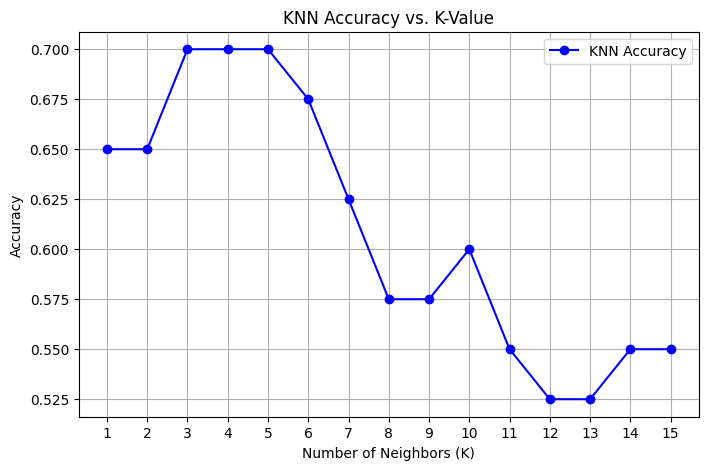

In [41]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label="KNN Accuracy")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. K-Value")
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.show()

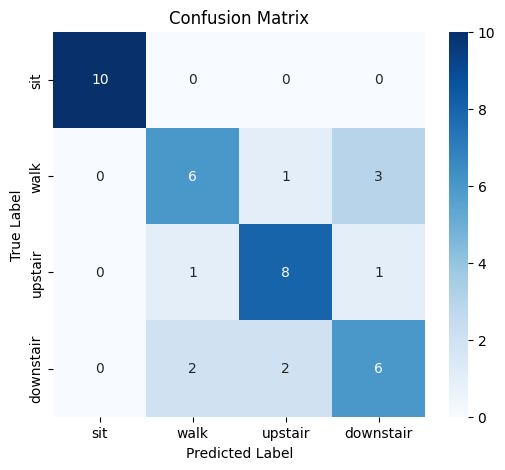

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = knn.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()